In [ ]:
!pip install -U scikit-learn

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow as tf


system = "jupyter"

In [2]:
# specify your directory and CSV file paths
if system == "linux":
    data_dir = "/fp/homes01/u01/ec-gerald/My Projects/ec192/data/endo-radiographs/clips"
elif system == "win":
    data_dir = r"\\aspasia.ad.fp.educloud.no\ec192\data\endo-radiographs\clips"
else:
    data_dir = "/fp/projects01/ec192/data/endo-radiographs/deniz/clips_balanced"
    
    
csv_file = os.path.join(data_dir, "codefile.csv")

image_size = 256

# load the CSV file using pandas
df = pd.read_csv(csv_file)
df.columns = ['filename', 'prediction']

# convert labels to str because ImageDataGenerator treats all inputs as strings
df['prediction'] = df['prediction'].astype(str)

# split the data into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# create ImageDataGenerators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# specify your target image size (this will be the input shape for your CNN)
target_size = (image_size, image_size)

In [3]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))  # output layer with 5 nodes

    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# create the model
model = create_model()

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

2023-06-15 10:30:17.167721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79149 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0


In [4]:
# specify batch size
batch_size = 64  

# create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=data_dir,
    x_col="filename",  # this might be "image_name" or something similar depending on your CSV
    y_col='prediction',  # this might be "diagnosis" or something similar depending on your CSV
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # use 'categorical' since we have now one-hot encoded labels
    color_mode='grayscale'
)

Found 914 validated image filenames belonging to 5 classes.
Found 229 validated image filenames belonging to 5 classes.


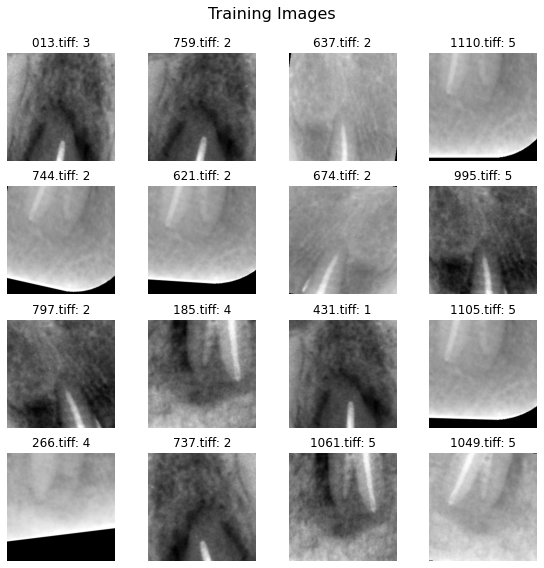

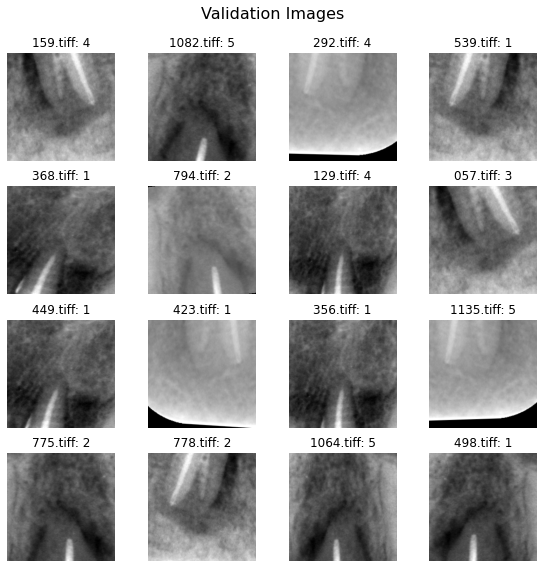

In [5]:
# Visualize data:
%matplotlib inline

# Function to get filenames from the generator
def get_filenames(generator):
    return generator.filenames

# Function to get class indices
def get_class_indices(generator):
    return generator.classes

# Fetch filenames and class indices for training and validation sets
train_filenames = get_filenames(train_generator)
train_class_indices = get_class_indices(train_generator)

valid_filenames = get_filenames(valid_generator)
valid_class_indices = get_class_indices(valid_generator)

# Get the class labels from class indices
label_map = (train_generator.class_indices)
inverse_label_map = {v: k for k, v in label_map.items()}

train_labels = [inverse_label_map[index] for index in train_class_indices]
valid_labels = [inverse_label_map[index] for index in valid_class_indices]

# Modified plot function to include file names and labels
def plot_images_with_labels(images, filenames, labels, title):
    fig, axes = plt.subplots(4, 4, figsize=(8,8))
    axes = axes.ravel()

    for i in np.arange(0, 16):
        axes[i].imshow(images[i].reshape(target_size), cmap='gray')
        axes[i].set_title(f"{filenames[i]}: {labels[i]}")
        axes[i].axis('off')
        #print(filenames[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # adjust the top spacing
    plt.suptitle(title, fontsize=16)  # use suptitle for better positioning
    plt.show()

# Plot images with labels
train_images, _ = next(train_generator)  # Get a batch of images from the generator
valid_images, _ = next(valid_generator)

plot_images_with_labels(train_images, train_filenames, train_labels, 'Training Images')
print("\n\n")
plot_images_with_labels(valid_images, valid_filenames, valid_labels, 'Validation Images')

In [9]:
# Train the model
epochs = 20

# Define the checkpoint and early stopping
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,  # steps_per_epoch should typically be equal to the total number of samples divided by the batch size
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps= len(valid_df) // batch_size,  # similar rule as steps_per_epoch but for the validation data
    callbacks=[early]
)

# Plot training & validation accuracy values
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig('accuracy.png')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('history.png')

model.save("my_model.h5")

2023-06-15 10:20:26.674473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-06-15 10:20:30.065712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-06-15 10:20:35.258900: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 14s 263ms/step - loss: 1.4747 - accuracy: 0.2706 - val_loss: 1.2207 - val_accuracy: 0.2865
Epoch 2/20
14/14 [==============================] - 1s 48ms/step - loss: 1.2305 - accuracy: 0.4341 - val_loss: 0.8958 - val_accuracy: 0.5625
Epoch 3/20
14/14 [==============================] - 1s 41ms/step - loss: 0.9680 - accuracy: 0.6282 - val_loss: 0.5908 - val_accuracy: 1.0000
Epoch 4/20
14/14 [==============================] - 1s 42ms/step - loss: 0.6587 - accuracy: 0.8082 - val_loss: 0.2705 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 1s 42ms/step - loss: 0.4846 - accuracy: 0.8082 - val_loss: 0.1066 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 1s 41ms/step - loss: 0.3306 - accuracy: 0.8647 - val_loss: 0.0471 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 1s 41ms/step - loss: 0.2966 - accuracy: 0.8718 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 8/20
14/14 [====

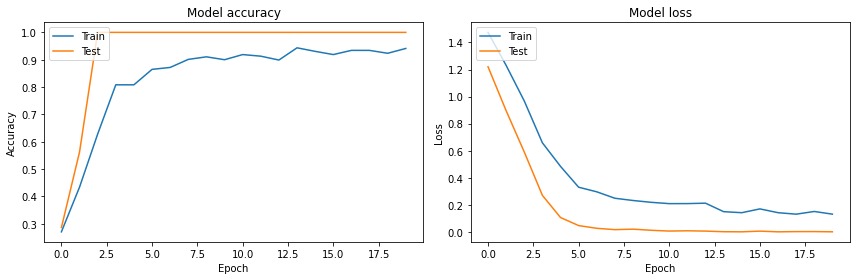

In [12]:
%matplotlib inline

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

Please enter the path to your file: /fp/projects01/ec192/data/endo-radiographs/deniz/anonymized/002.tiff


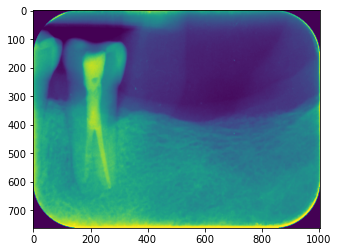

In [6]:
file_path = input("Please enter the path to your file: ")

# /fp/projects01/ec192/data/endo-radiographs/deniz/anonymized/002.tiff

# Now you can use the `file_path` variable to load your file
# For example, to load an image with matplotlib:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread(file_path)
imgplot = plt.imshow(img)
plt.show()